In [220]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)


In [221]:
# Part a

# Load the data set
df = pd.read_csv("data/P1/dataset.csv")

# Drop rows with missing values in target features and indices
df.dropna(subset=["Next_Tmax", "Next_Tmin", "Date", "station"], inplace=True)

# Split index, features, and targets
I = df[["Date", "station"]]
X = df.drop(columns=["Date", "station", "Next_Tmax", "Next_Tmin"])
Y = df[["Next_Tmax", "Next_Tmin"]]
I["station"] = I["station"].astype(int)

# Extract Day and Month from the Date column (potentially valuable features)
X["Day"] = pd.to_datetime(I["Date"]).dt.day
X["Month"] = pd.to_datetime(I["Date"]).dt.month

# Normalize using standard scaler and impute missing values with mean
X = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
X = X.fillna(0)


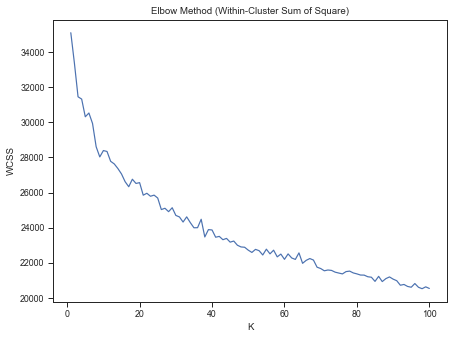

In [222]:
# Remove outliers using k-means

def Euclidean(x, X):
    """Return the Euclidean distances between
    an instance x and the dataset X."""
    return np.sqrt(np.sum((x - X)**2, axis=1))


def KMeans(X, ClusterCount=2, Iteration=100, ConvergenceRatio=1e6, DistanceMetric=Euclidean):

    # Select clusters' centers
    centers = []
    selected = set()
    idx = list(range(X.shape[0]))

    # Select the first center randomly.
    c1 = np.random.choice(idx)
    selected.add(c1)
    centers.append(X[c1])

    # Select the farthest points as other centers with higher probabilities.
    for i in range(ClusterCount - 1):
        dists = np.sum([DistanceMetric(c, X) for c in centers], axis=0)
        dists /= np.sum(dists)
        while True:
            ci = np.random.choice(idx, size=1, replace=False, p=dists)[0]
            if ci not in selected:
                selected.add(ci)
                centers.append(X[ci])
                break

    # Update clusters
    for iter in range(Iteration):
        # Assign each instance to the nearest cluster.
        clusters = [[] for _ in range(ClusterCount)]
        for x in X:
            dists = DistanceMetric(x, centers)
            clusters[np.argmin(dists)].append(x)

        # Update clusters' centers
        prev_centers = centers
        centers = [np.mean(c, axis=0) for c in clusters]

        # Stop updating if converged
        if np.sum(np.abs(np.array(centers) - np.array(prev_centers))) < ConvergenceRatio:
            break

    return np.array(centers)


def distance_from_center(X, centers, DistanceMetric=Euclidean):
    distance = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        dists = DistanceMetric(X[i], centers)
        distance[i] = np.min(dists)
    return distance


def elbow(X, max_k=100, fig_path="P1_a_elbow.png"):
    K = list(range(1, max_k + 1))
    wcss = []
    for k in K:
        centers = KMeans(X, k)
        distances = distance_from_center(X, centers)
        wcss.append(np.sum(distances))
    fig, ax = plt.subplots()
    ax.set(
        title="Elbow Method (Within-Cluster Sum of Square)",
        xlabel="K",
        ylabel="WCSS"
    )
    sns.lineplot(x=K, y=wcss, ax=ax)
    fig.savefig(fig_path)
    plt.show()


elbow(X.values)


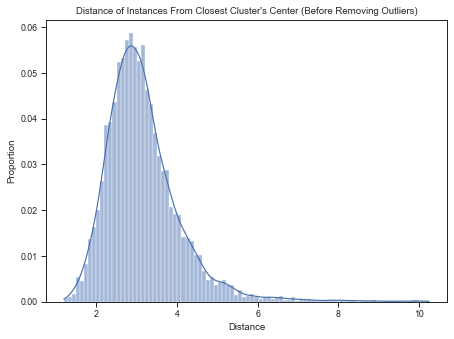

In [223]:
# Dataset status before removing outliers
centers = KMeans(X.values, 30)
dist = distance_from_center(X.values, centers)
ax = sns.histplot(x=dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center (Before Removing Outliers)", xlabel='Distance')
plt.savefig('P1_a_before_outlier.png')
plt.show()


Proportion of outliers: 0.0131


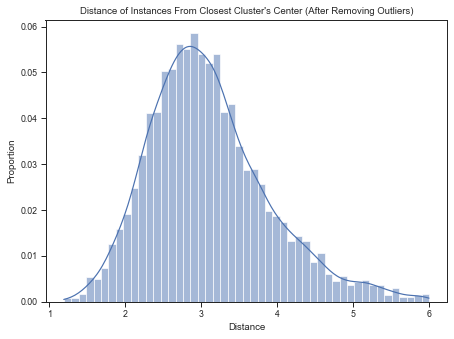

In [224]:
# Remove outliers
outlier_thr = 6.0
outlier_proportion = np.sum(dist >= outlier_thr) / len(Y)
I = I[dist < outlier_thr]
X = X[dist < outlier_thr]
Y = Y[dist < outlier_thr]
dist = dist[dist < outlier_thr]

# Dataset status after removing outliers
print('Proportion of outliers:', round(outlier_proportion, 4))
ax = sns.histplot(x=dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center (After Removing Outliers)", xlabel='Distance')
plt.savefig('P1_a_after_outlier.png')
plt.show()


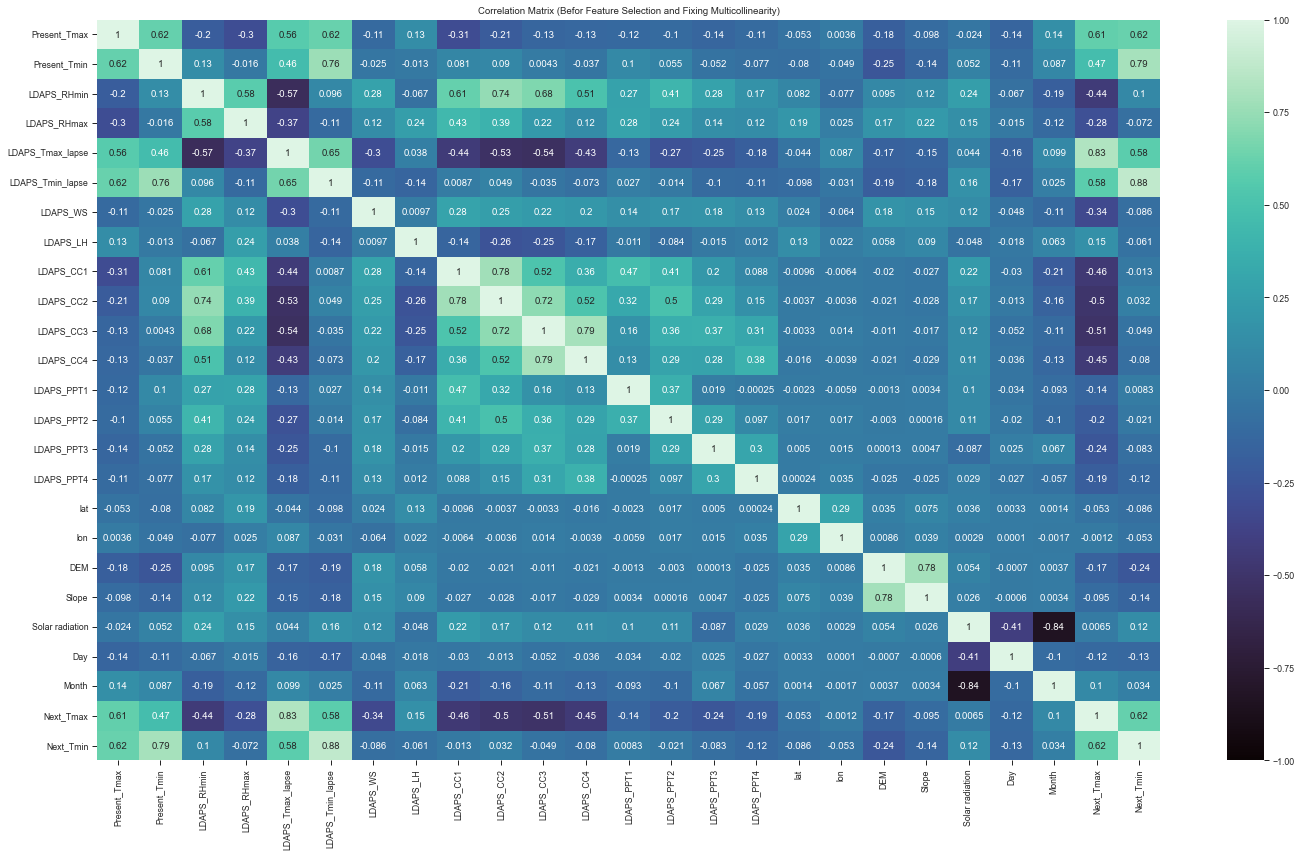

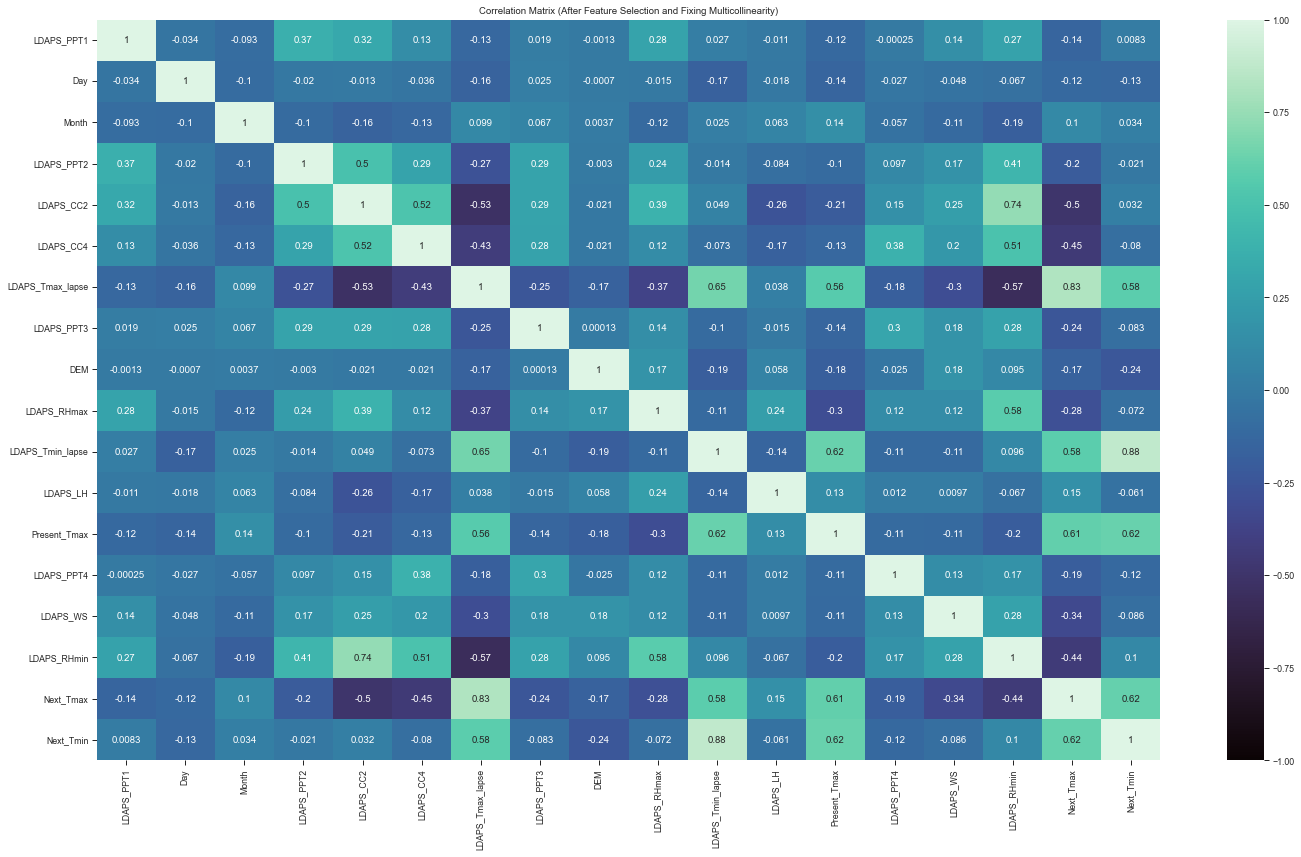

In [225]:
# Select important features and remove highly correlated features

def select_features(X, Y, thr=0.10):
    cor = np.abs(pd.concat([X, Y], axis=1).corr())
    s = set()
    for y in Y.columns:
        for x in X.columns:
            if cor[y][x] > thr:
                s.add(x)
    return X[list(s)]


def fix_multicollinearity(X, Y, thr=0.75):
    cor = np.abs(pd.concat([X, Y], axis=1).corr())
    drops = set()
    for i in X.columns:
        for j in X.columns:
            if i == j:
                continue
            if cor[i][j] > thr:
                min_f, min_cor = i, cor[Y.columns[0]][i]
                for k in Y.columns:
                    if cor[k][i] < min_cor:
                        min_f, min_cor = i, cor[k][i]
                    if cor[k][j] < min_cor:
                        min_f, min_cor = j, cor[k][j]
                drops.add(min_f)
    return X.drop(columns=list(drops))


corr_mat = pd.concat([X, Y], axis=1).corr()
fig, ax = plt.subplots(figsize=(20, 12))
ax.set(title="Correlation Matrix (Befor Feature Selection and Fixing Multicollinearity)")
sns.heatmap(corr_mat, annot=True, ax=ax, vmin=-1, vmax=1, cmap="mako")
fig.savefig("P1_a_before_feature.png")
plt.show()


X = select_features(X, Y)
X = fix_multicollinearity(X, Y)

corr_mat = pd.concat([X, Y], axis=1).corr()
fig, ax = plt.subplots(figsize=(20, 12))
ax.set(title="Correlation Matrix (After Feature Selection and Fixing Multicollinearity)")
sns.heatmap(corr_mat, annot=True, ax=ax, vmin=-1, vmax=1, cmap="mako")
fig.savefig("P1_a_after_feature.png")
plt.show()


In [226]:
# Split data to train and test

year = pd.to_datetime(I["Date"]).dt.year
train_idx = year < 2016
I_train, I_test = I[train_idx], I[~train_idx]
X_train, X_test = X[train_idx], X[~train_idx]
Y_train, Y_test = Y[train_idx], Y[~train_idx]


In [227]:
# Part b

def prep(X, deg=1):
    intercept = np.ones((X.shape[0], 1))
    X_new = np.c_[intercept, X]
    for i in range(X.shape[1]):
        for d in range(2, deg + 1):
            X_new = np.c_[X_new, X[:, i] ** d]
    return X_new


def sse(y_true, y_pred):
    err = np.sum((y_pred - y_true) ** 2)
    return err


def RegressionTrainerGD(X, y, learning_rate=1e-2, max_iter=10000, tol=1e-10, l2=0):
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    for it in range(max_iter):
        g = X.T @ (X @ w - y) + 2 * l2 * np.sum(w)
        g /= m
        w_prev = w
        w = w - learning_rate * g
        if np.sum(np.square(w - w_prev)) < tol:
            break
    return w


SSE for Next_Tmax: 8481.8899


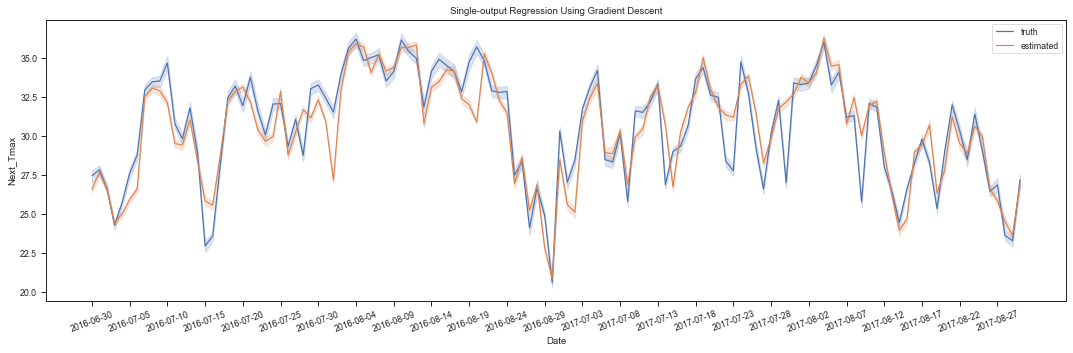

In [228]:
D = 1
LR = 1e-2

X_train_p, X_test_p = prep(X_train.values, D), prep(X_test.values, D)
y_train = Y_train["Next_Tmax"].values
w = RegressionTrainerGD(X_train_p, y_train, LR)
y_true = Y_test["Next_Tmax"].values
y_pred = X_test_p @ w
e = sse(y_true, y_pred)


print("SSE for Next_Tmax:", round(e, 4))

df = I_test.copy()
df["True"] = y_true
df["Pred"] = y_pred
fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Single-output Regression Using Gradient Descent", xlabel="Date", ylabel="Next_Tmax")
sns.lineplot(df, x="Date", y="True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_b.png")
plt.show()


Total SSE: 12513.7757
SSE for Next_Tmax: 8481.9516
SSE for Next_Tmin: 4031.8241


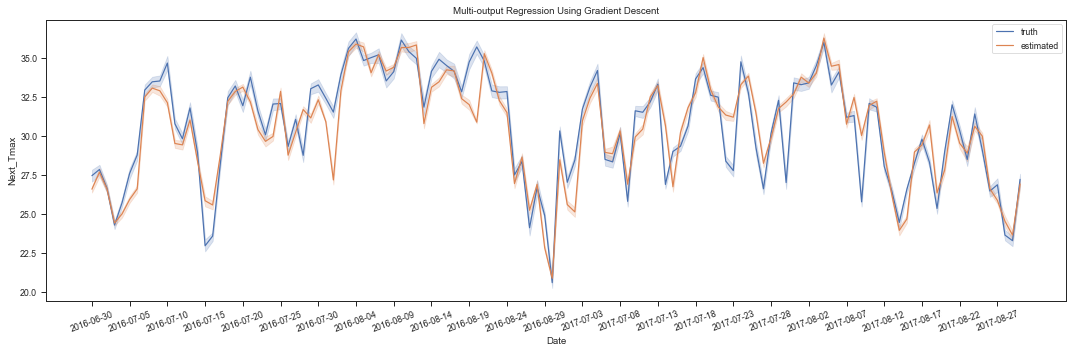

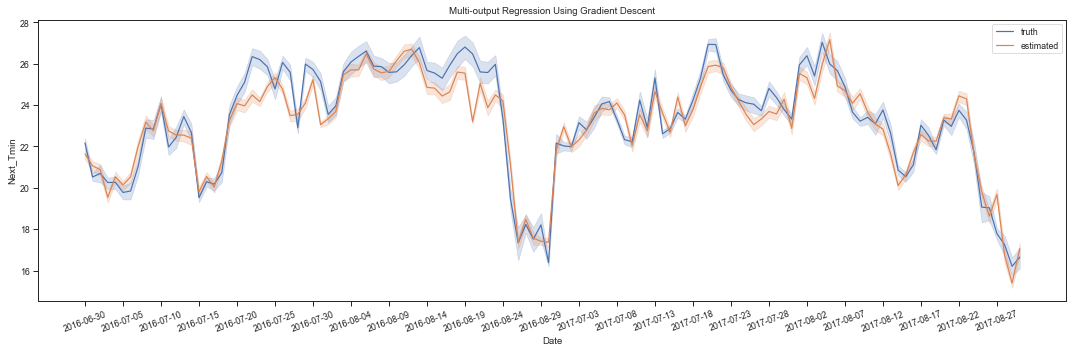

In [229]:
# Part d

def MORTGD(X, Y, learning_rate=1e-2, max_iter=10000, tol=1e-10, l2=0):
    """Multi-output Regression Trainer Using Gradient Descent"""
    m = X.shape[0]
    W = np.zeros((X.shape[1], Y.shape[1]))
    for it in range(max_iter):
        G = X.T @ (X @ W - Y) + 2 * l2 * np.sum(W)
        G /= m
        W_prev = W
        W = W - learning_rate * G
        if np.sum(np.square(W - W_prev)) < tol:
            break
    return W


D = 1
LR = 1e-2

X_train_p, X_test_p = prep(X_train.values, D), prep(X_test.values, D)
W = MORTGD(X_train_p, Y_train.values, LR)
Y_pred = X_test_p @ W
total_e = sse(Y_test.values, Y_pred)
tmax_e = sse(Y_test["Next_Tmax"].values, Y_pred[:, 0])
tmin_e = sse(Y_test["Next_Tmin"].values, Y_pred[:, 1])


print("Total SSE:", round(total_e, 4))
print("SSE for Next_Tmax:", round(tmax_e, 4))
print("SSE for Next_Tmin:", round(tmin_e, 4))

df = I_test.copy()
df["Tmax_True"] = Y_test["Next_Tmax"]
df["Tmin_True"] = Y_test["Next_Tmin"]
df["Tmax_Pred"] = Y_pred[:, 0]
df["Tmin_Pred"] = Y_pred[:, 1]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using Gradient Descent", xlabel="Date", ylabel="Next_Tmax")
sns.lineplot(df, x="Date", y="Tmax_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmax_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_d_1.png")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using Gradient Descent", xlabel="Date", ylabel="Next_Tmin")
sns.lineplot(df, x="Date", y="Tmin_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmin_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_d_2.png")
plt.show()


Total SSE: 12520.0062
SSE for Next_Tmax: 8488.099
SSE for Next_Tmin: 4031.9072


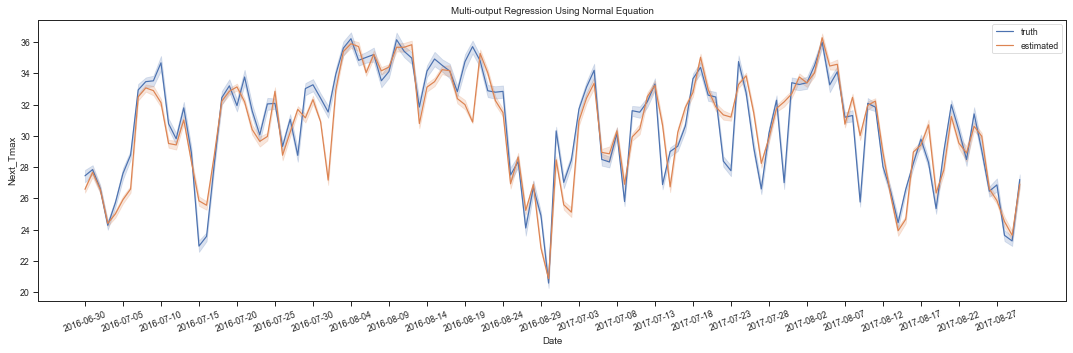

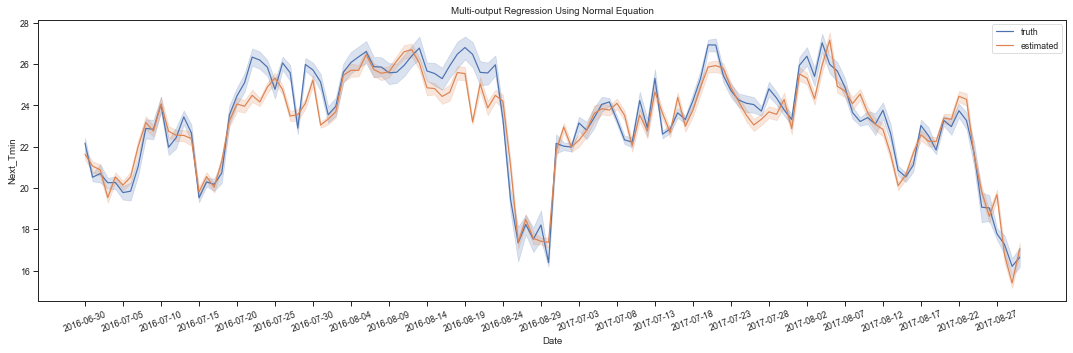

In [230]:
def MORTNE(X, Y):
    """Multi-output Regression Trainer Using Normal Equation"""
    W = np.linalg.inv(X.T @ X) @ X.T @ Y
    return W


D = 1

X_train_p, X_test_p = prep(X_train.values, D), prep(X_test.values, D)
W = MORTNE(X_train_p, Y_train.values)
Y_pred = X_test_p @ W
total_e = sse(Y_test.values, Y_pred)
tmax_e = sse(Y_test["Next_Tmax"].values, Y_pred[:, 0])
tmin_e = sse(Y_test["Next_Tmin"].values, Y_pred[:, 1])


print("Total SSE:", round(total_e, 4))
print("SSE for Next_Tmax:", round(tmax_e, 4))
print("SSE for Next_Tmin:", round(tmin_e, 4))

df = I_test.copy()
df["Tmax_True"] = Y_test["Next_Tmax"]
df["Tmin_True"] = Y_test["Next_Tmin"]
df["Tmax_Pred"] = Y_pred[:, 0]
df["Tmin_Pred"] = Y_pred[:, 1]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using Normal Equation", xlabel="Date", ylabel="Next_Tmax")
sns.lineplot(df, x="Date", y="Tmax_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmax_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_f_1.png")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using Normal Equation", xlabel="Date", ylabel="Next_Tmin")
sns.lineplot(df, x="Date", y="Tmin_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmin_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_f_2.png")
plt.show()


Total SSE: 19536.1024
SSE for Next_Tmax: 11314.3245
SSE for Next_Tmin: 8221.778


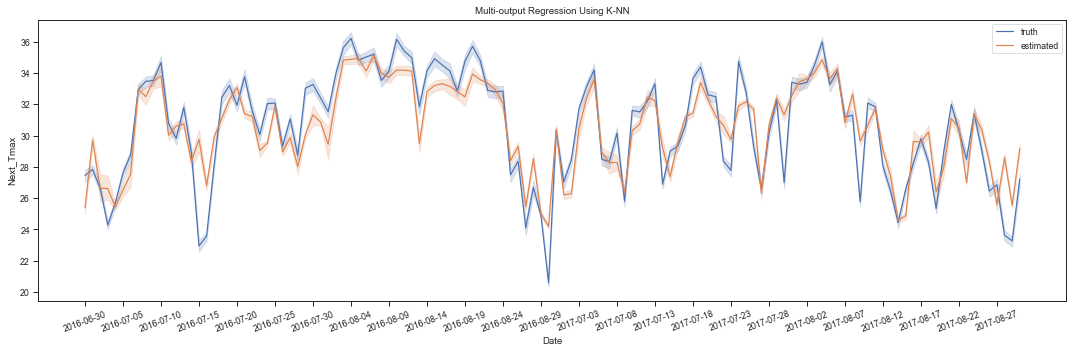

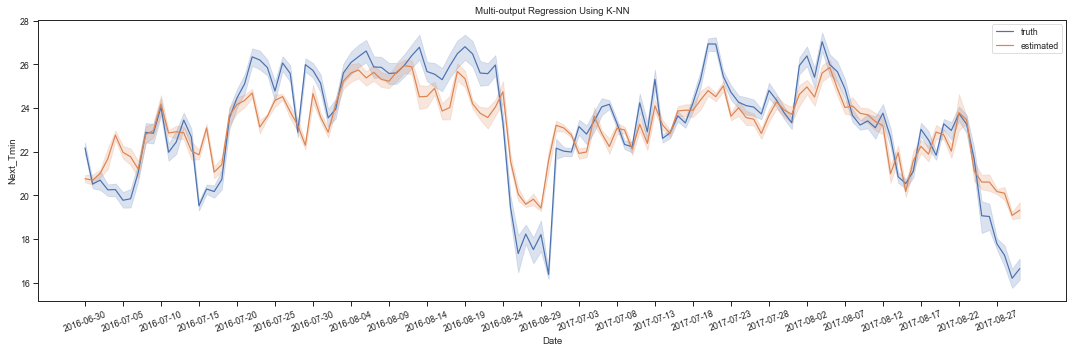

In [231]:
# Part G

def KNeighborsRegressor(X, Y, X_test, k=7):
    """Multi-output Regression Using KNN"""
    Y_pred = np.zeros((X_test.shape[0], Y.shape[1]))
    for i, x in enumerate(X_test):
        dist = np.sqrt(np.sum((x - X)**2, axis=1))
        neighbors = Y[np.argsort(dist)[:k]]
        Y_pred[i] = np.mean(neighbors, axis=0)
    return Y_pred


Y_pred = KNeighborsRegressor(X_train.values, Y_train.values, X_test.values)

total_e = sse(Y_test.values, Y_pred)
tmax_e = sse(Y_test["Next_Tmax"].values, Y_pred[:, 0])
tmin_e = sse(Y_test["Next_Tmin"].values, Y_pred[:, 1])

print("Total SSE:", round(total_e, 4))
print("SSE for Next_Tmax:", round(tmax_e, 4))
print("SSE for Next_Tmin:", round(tmin_e, 4))

df = I_test.copy()
df["Tmax_True"] = Y_test["Next_Tmax"]
df["Tmin_True"] = Y_test["Next_Tmin"]
df["Tmax_Pred"] = Y_pred[:, 0]
df["Tmin_Pred"] = Y_pred[:, 1]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using K-NN", xlabel="Date", ylabel="Next_Tmax")
sns.lineplot(df, x="Date", y="Tmax_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmax_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_g_1.png")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title="Multi-output Regression Using K-NN", xlabel="Date", ylabel="Next_Tmin")
sns.lineplot(df, x="Date", y="Tmin_True", ax=ax, label="truth")
sns.lineplot(df, x="Date", y="Tmin_Pred", ax=ax, label="estimated")
ax.set_xticks(ax.get_xticks()[::5])
ax.tick_params(axis='x', rotation=20)
fig.savefig("P1_g_2.png")
plt.show()
